In [1]:
import pandas as pd
import numpy as np
from arch.unitroot import DFGLS
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df = pd.read_stata("TB.dta")
df["r3m"] = pd.to_numeric(df["r3m"], errors="coerce")
df["r1y"] = pd.to_numeric(df["r1y"], errors="coerce")
df["r3y"] = pd.to_numeric(df["r3y"], errors="coerce")
df["r5y"] = pd.to_numeric(df["r5y"], errors="coerce")
df["r10y"] = pd.to_numeric(df["r10y"], errors="coerce")

#df.set_index('fecha',inplace=True)
# crear una nueva coluna con fecha mapeando meses de castellano a ingles

## usar una forma mas compacta al estilo de python
# meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']
meses_en = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for mes, mes_en in zip(meses, meses_en):
    df['fecha'] = df['fecha'].str.replace(mes, mes_en)

## convertir los años a 4 dígitos empezando de 1950 hasta 2023
df['fecha'] = df['fecha'].str.replace(r'-(\d{2})$', lambda x: f'-19{x.group(1)}' if int(x.group(1)) >= 50 else f'-20{x.group(1)}', regex=True)

df['fecha'] = pd.to_datetime(df['fecha'], format='%d-%b-%Y',dayfirst=True)
df.set_index('fecha', inplace=True)
df

,r3m,r1y,r3y,r5y,r10y
fecha,,,,,
1962-01-02,2.70,3.22,3.70,3.88,4.06
1962-01-03,2.73,3.24,3.70,3.87,4.03
1962-01-04,2.72,3.24,3.69,3.86,3.99
1962-01-05,2.74,3.26,3.71,3.89,4.02
1962-01-06,2.74,3.26,3.71,3.89,4.02
...,...,...,...,...,...
2021-12-26,0.06,0.27,0.97,1.24,1.49
2021-12-27,0.04,0.28,0.98,1.25,1.48
2021-12-28,0.04,0.28,0.97,1.25,1.48


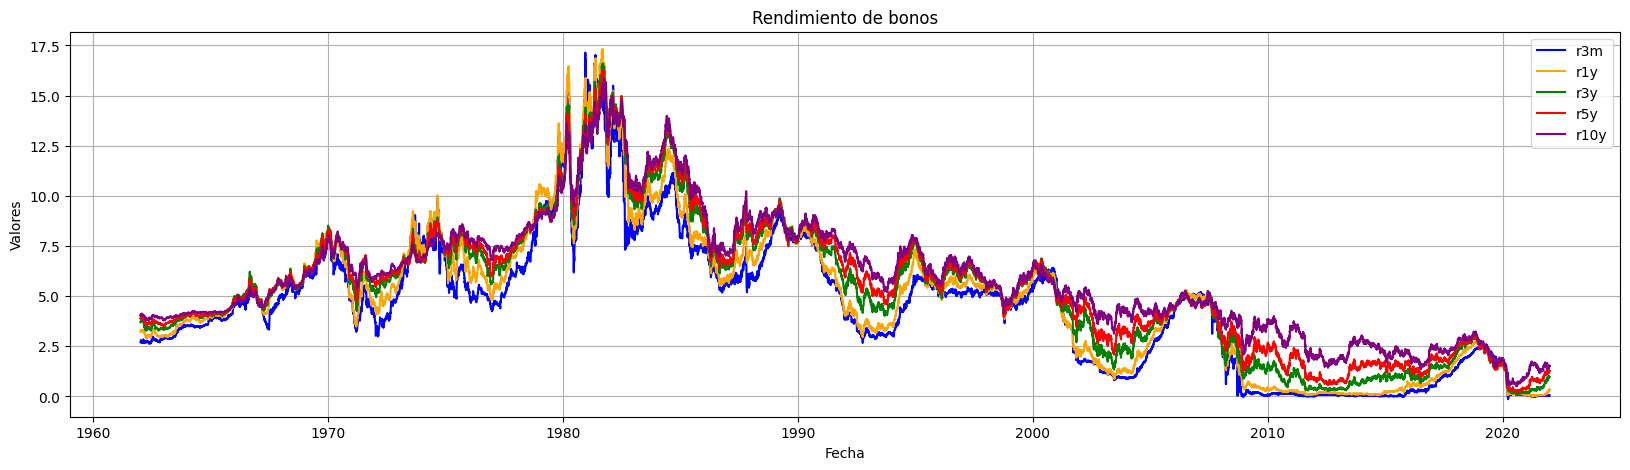

In [3]:
def graficar_serie_con_base(df, titulo,columns=['r3m','r1y','r3y','r5y','r10y']):
    plt.figure(figsize=(20, 5))
    plt.plot(df.index, df[columns[0]], color='blue', label='r3m')
    plt.plot(df.index, df[columns[1]], color='orange', label='r1y')
    plt.plot(df.index, df[columns[2]], color='green', label='r3y')
    plt.plot(df.index, df[columns[3]], color='red', label='r5y')
    plt.plot(df.index, df[columns[4]], color='purple', label='r10y')
    plt.title(titulo)
    plt.xlabel('Fecha')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid()
    plt.show()

graficar_serie_con_base(df, 'Rendimiento de bonos')

### Vemos el orden de integracion según DFA para cada serie
Según la documentacion lo mas parecido es usar DLGS con t-stats sin tendencia

In [4]:
from arch.unitroot import DFGLS


for columna in df.columns:
    result=DFGLS(df[columna].dropna(),trend='ct',method='t-stat')
    print(f"DFGLS {columna}:\n", result.summary())
    if result.pvalue < 0.05:
        print(f"Rechazamos H0: por lo tanto la serie {columna} es estacionaria")
    else:
        print(f"No rechazamos H0:  por lo tanto  la serie {columna} no es estacionaria")
    print("\n\n")


#Indique el orden de integración de cada una de las series, utilizando el estadístico de Dickey Fuller aumentado con la cantidad de lags que sugiere el criterio de selección de lags de Ng-Perron. Use un nivel de significancia de 5% en cada test.




DFGLS r3m:
       Dickey-Fuller GLS Results      
Test Statistic                 -1.995
P-value                         0.304
Lags                               47
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.41 (1%), -2.85 (5%), -2.56 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
No rechazamos H0:  por lo tanto  la serie r3m no es estacionaria



DFGLS r1y:
       Dickey-Fuller GLS Results      
Test Statistic                 -1.808
P-value                         0.403
Lags                               47
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.41 (1%), -2.85 (5%), -2.56 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
No rechazamos H0:  por lo tanto  la serie r1y no es estacionaria



DFGLS r3y:
       Dickey-Fuller GLS Results      
Test Sta

Todas las series dieron NO estacionarias, asi que ahora vamos por las primeras diferencias

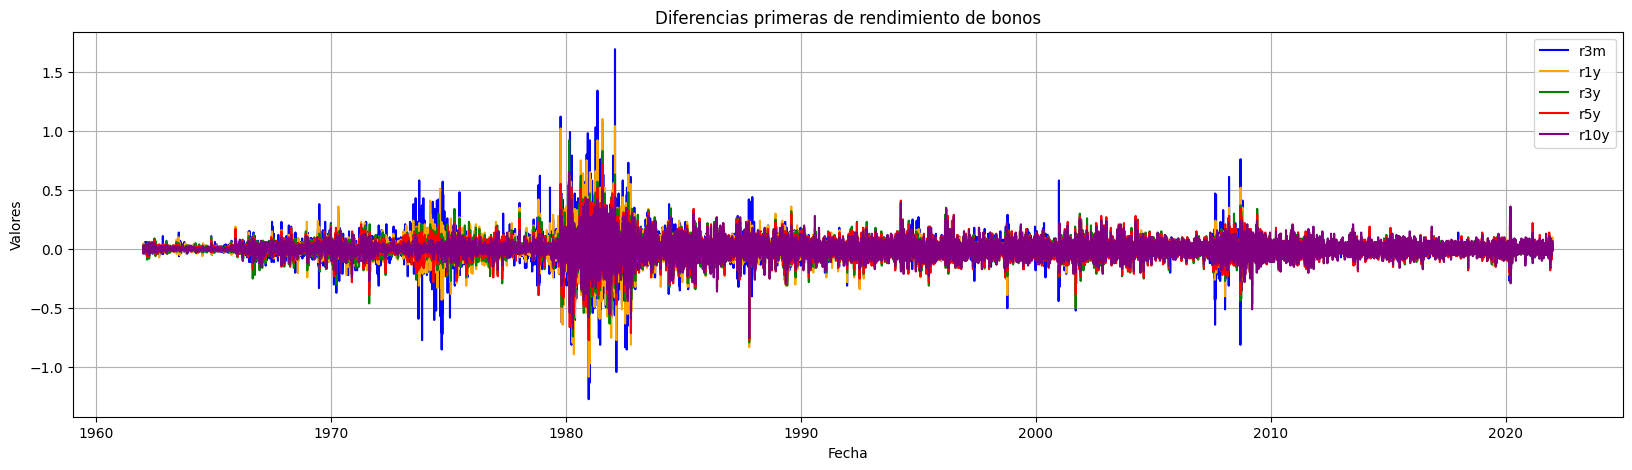

In [5]:
## calculamos las primeras diferencias para cada una de las series
df_diff=df.copy()
df_diff['dr3m']=df_diff['r3m'].diff()
df_diff['dr1y']=df_diff['r1y'].diff()
df_diff['dr3y']=df_diff['r3y'].diff()
df_diff['dr5y']=df_diff['r5y'].diff()
df_diff['dr10y']=df_diff['r10y'].diff()


## elimino las filas r3m 
df_diff.drop(columns=['r3m','r1y','r3y','r5y','r10y'],inplace=True)
##df_diff = df_diff.dropna()

graficar_serie_con_base(df_diff.dropna(), 'Diferencias primeras de rendimiento de bonos',columns=['dr3m','dr1y','dr3y','dr5y','dr10y'])

Ahora tiene mas pinta de estacionario, salvo por algunas crisis parece

In [6]:

for columna in df_diff.columns:
    result=DFGLS(df_diff[columna].dropna(),trend='ct',method='t-stat')
    print(f"DFGLS {columna}:\n", result.summary())
    if result.pvalue < 0.05:
        print(f"Rechazamos H0: la serie {columna} es estacionaria")
    else:
        print(f"No rechazamos H0: la serie {columna} no es estacionaria")
    print("\n\n")


DFGLS dr3m:
       Dickey-Fuller GLS Results      
Test Statistic                -13.790
P-value                         0.000
Lags                               47
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.41 (1%), -2.85 (5%), -2.56 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Rechazamos H0: la serie dr3m es estacionaria



DFGLS dr1y:
       Dickey-Fuller GLS Results      
Test Statistic                -16.534
P-value                         0.000
Lags                               47
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.41 (1%), -2.85 (5%), -2.56 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Rechazamos H0: la serie dr1y es estacionaria



DFGLS dr3y:
       Dickey-Fuller GLS Results      
Test Statistic                -20.206
P-value

### Quedo verificado que son todas de I(1)

In [8]:
# 1) (comentado) Podrías testear raíces unitarias por serie como arriba (DFGLS/ADF)

# 2) Selección de lags (equivalente a varsoc en Stata)
# Usamos VAR.select_order (AIC, BIC, FPE, HQIC)
cols_all = ['r3m', 'r1y', 'r3y', 'r5y', 'r10y']
varsel = VAR(df[cols_all].dropna()).select_order(maxlags=12)
print("Selección de rezagos (VAR):")
print(varsel.summary())

/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Selección de rezagos (VAR):
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -8.452      -8.450   0.0002135      -8.451
1       -33.75      -33.74   2.209e-15      -33.74
2       -33.78     -33.76*   2.139e-15      -33.77
3       -33.78      -33.75   2.135e-15      -33.77
4       -33.79      -33.75   2.123e-15      -33.77
5       -33.79      -33.74   2.119e-15      -33.77
6       -33.79      -33.74   2.109e-15      -33.77
7       -33.79      -33.73   2.104e-15      -33.77
8       -33.81      -33.73   2.075e-15      -33.78
9       -33.81      -33.73   2.063e-15      -33.79
10      -33.82      -33.72   2.061e-15      -33.79
11      -33.82      -33.72   2.050e-15      -33.79
12     -33.83*      -33.71  2.041e-15*     -33.79*
--------------------------------------------------


### Usamos el criterio de BIC y tomamos 2 como lags

In [9]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

In [10]:

k_ar_diff = 2  # ajustá acorde a selección de rezagos (lags en diferencias) aca usamos BIC por ejemplo
det_order = 0  # ~ trend(constant) de Stata

jres = coint_johansen(df[cols_all].dropna(), det_order=det_order, k_ar_diff=k_ar_diff)

print("Johansen TRACE stats:", jres.lr1)
print("Johansen TRACE crit (90,95,99):\n", jres.cvt)


Johansen TRACE stats: [522.83629156 259.24115802  72.35495251  17.08235781   1.49664497]
Johansen TRACE crit (90,95,99):
 [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]



### b) Al 1% son 4 niveles de cointegracion (arranco a contar desde 0) y continuo hasta que no puedo rechazar. Rechazo cuando el estadistico es mayor el el VC rechazo.

### c) En función a su respuesta a la pregunta anterior, estime un modelo VEC e indique qué relaciones de cointegración encuentra (es decir, especifíquelas). Justifique detalladamente las opciones que usa (u omite) para estimar el VEC.

In [11]:
rank = 4  # como en Stata: vec ..., rank(4)
vecm = VECM(df[cols_all].dropna(), k_ar_diff=k_ar_diff, coint_rank=rank, deterministic="co")  # 'co' ≈ constant in cointegration relation
vecm_res = vecm.fit()
print(vecm_res.summary())

/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Det. terms outside the coint. relation & lagged endog. parameters for equation r3m
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.100      0.920      -0.002       0.002
L1.r3m         0.0409      0.010      4.093      0.000       0.021       0.061
L1.r1y         0.1058      0.017      6.134      0.000       0.072       0.140
L1.r3y        -0.0526      0.028     -1.853      0.064      -0.108       0.003
L1.r5y        -0.0131      0.034     -0.381      0.703      -0.080       0.054
L1.r10y       -0.0077      0.025     -0.303      0.762      -0.058       0.042
L2.r3m        -0.0104      0.010     -1.047      0.295      -0.030       0.009
L2.r1y      5.228e-05      0.017      0.003      0.998      -0.034       0.034
L2.r3y         0.0194      0.028      0.685      0.493      -0.036       0.075
L2.r5y        -0.0274      0.034     -0.800     